# Temperature, Salinity, and Stratification #

In [6]:
import xray
from matplotlib import pyplot as plt
import seaborn
import numpy as np
import gsw
seaborn.set()
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,7)

In [2]:
woa = xray.open_dataset('http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NODC/.WOA09/'
                        '.Grid-1x1/.Annual/dods')

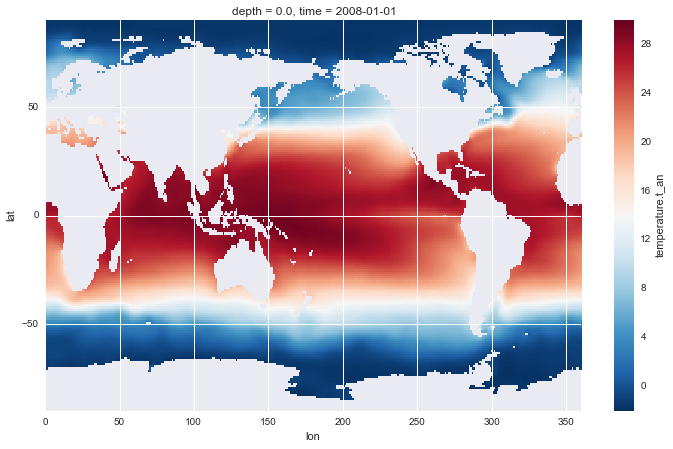

In [3]:
woa['temperature.t_an'][0,0].plot(yincrease=True, vmax=30, center=14)

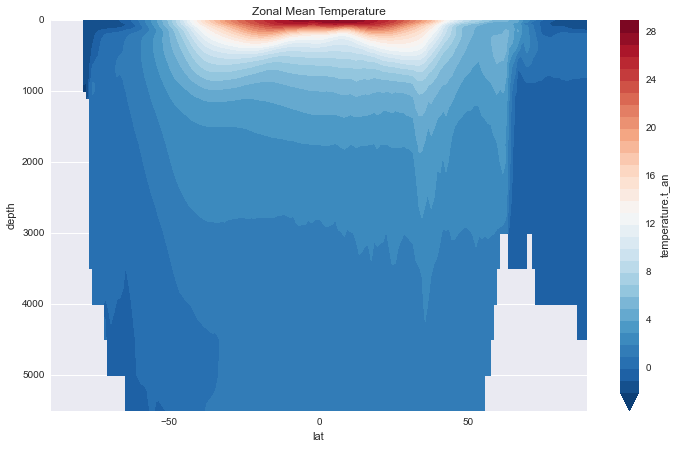

In [9]:
fig, ax = plt.subplots()
woa['temperature.t_an'][0].mean(dim='lon').plot.contourf(
    yincrease=False, vmax=30, center=14, levels=np.arange(-2,30))
ax.set_title('Zonal Mean Temperature')

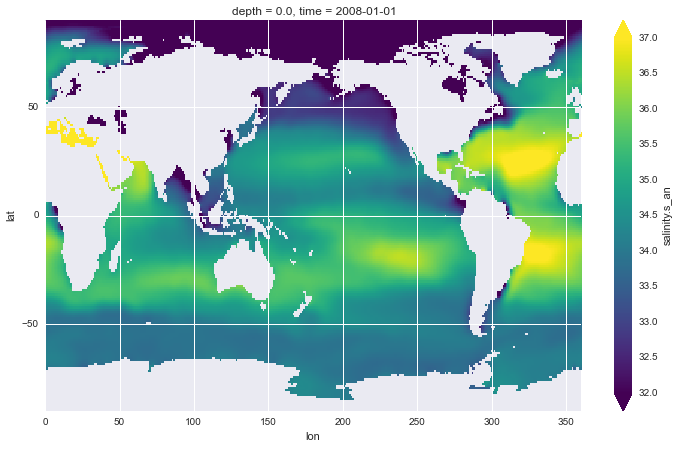

In [7]:
woa['salinity.s_an'][0,0].plot(yincrease=True, vmax=37, vmin=32)

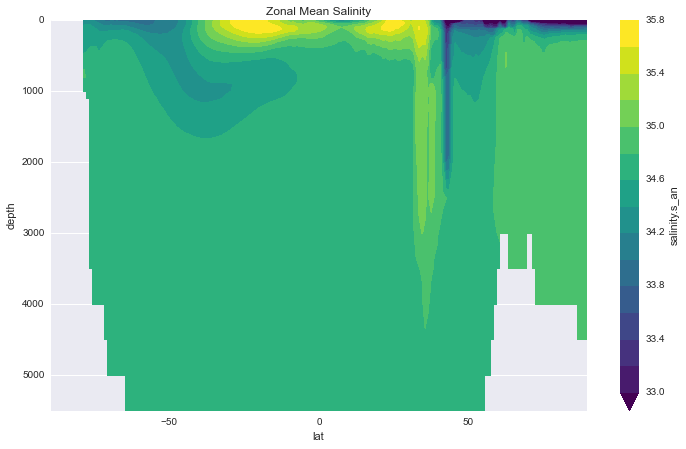

In [8]:
fig, ax = plt.subplots()
woa['salinity.s_an'][0].mean(dim='lon').plot.contourf(
    yincrease=False, levels=np.arange(33,36,0.2))
ax.set_title('Zonal Mean Salinity')

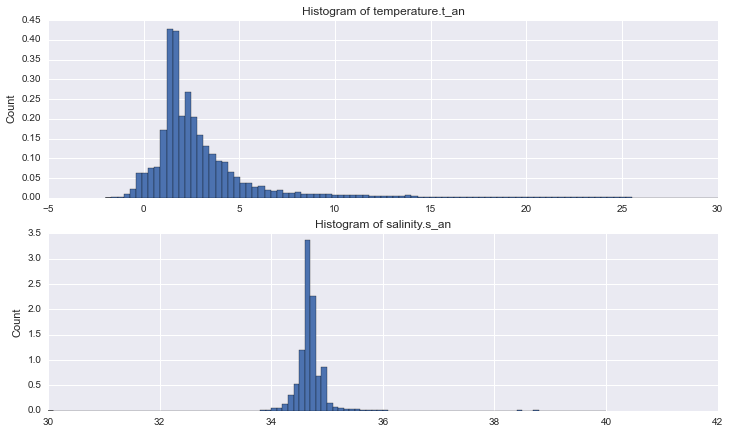

In [115]:
woa['thick'] = woa.depth.diff(dim='depth')
# add an area element
woa['area'] = (gsw.earth.earth_radius**2 *
               np.radians(1.) * np.radians(1.) *
               np.cos(np.radians(woa.lat)))
t, s, dz, a  = xray.broadcast_arrays(
                *xray.align(
                    woa['temperature.t_an'], woa['salinity.s_an'],
                    woa['thick'], woa['area'] 
                )
              )
vol = dz*a

fig, (ax1, ax2) = plt.subplots(2)

# uncomment to make log scale
#[ax.set_yscale('log') for ax in [ax1, ax2]]

t.plot.hist(bins=100, ax=ax1,
            normed=True, range=(-2,30),
            weights=np.ma.masked_invalid(vol.where(~np.isnan(t)).values).compressed());

s.plot.hist(bins=100, ax=ax2,
            normed=True, range=(30,40),
            weights=np.ma.masked_invalid(vol.where(~np.isnan(s)).values).compressed());


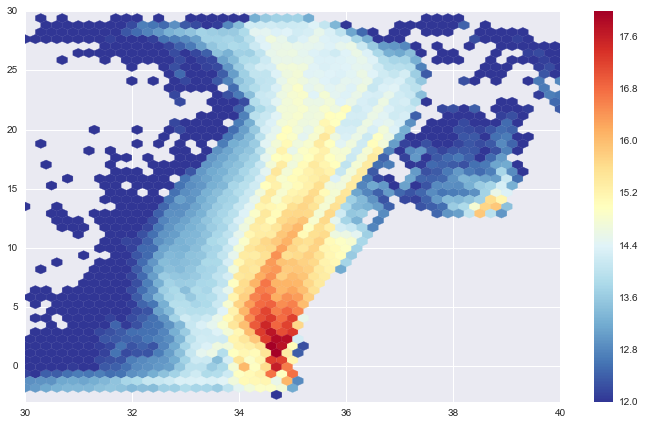

In [133]:
from matplotlib.colors import LogNorm
plt.hexbin(s.values.ravel(), t.values.ravel(),
           C=vol.values.ravel(), reduce_C_function=np.sum,
           extent=(30,40,-3,30), gridsize=50, bins='log',
           cmap='RdYlBu_r')
plt.colorbar()
plt.clim([12,18])

In [188]:
# the goods are here
# https://www.nodc.noaa.gov/OC5/3M_HEAT_CONTENT/
# http://data.nodc.noaa.gov/thredds/catalog/woa/heat_content/heat_content/catalog.html
hc = xray.open_dataset('http://data.nodc.noaa.gov/thredds/dodsC/woa/'
                       'heat_content/heat_content/heat_content_anomaly_0-700_pentad.nc',
                        decode_times=False)
# fix time to something xray likes
hc.time *= (365/12.)
tunits = hc.time.attrs['units'].replace('months', 'days')
hc.time.attrs['units'] = tunits
hc = xray.decode_cf(hc)

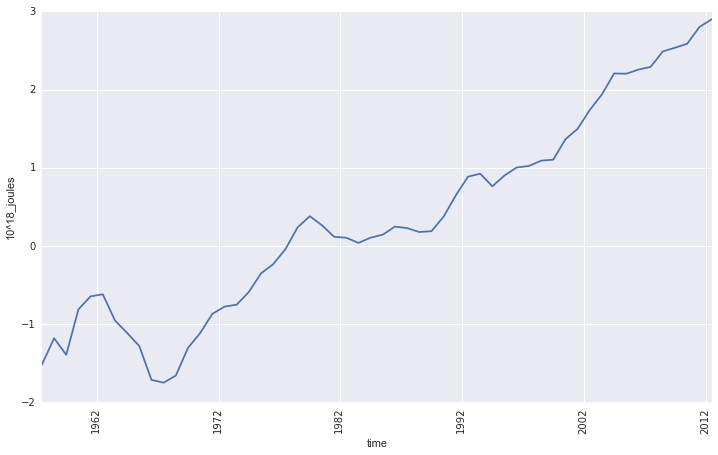

In [192]:
fig, ax = plt.subplots()
hc['h18_hc'].mean(dim=('lon','lat','depth')).plot(ax=ax)
ax.set_ylabel(hc.h18_hc.attrs['units'])

In [187]:
hc.time.attrs

OrderedDict([(u'standard_name', u'time'), (u'long_name', u'time'), (u'units', u'days since 1955-01-01 00:00:00'), (u'axis', u'T'), (u'climatology', u'climatology_bounds')])

In [160]:
f.replace('fa','FA')

'FAt'

In [12]:
woa['thick']

<xray.DataArray 'thick' (depth: 33)>
array([    0.,    10.,    20.,    30.,    50.,    75.,   100.,   125.,
         150.,   200.,   250.,   300.,   400.,   500.,   600.,   700.,
         800.,   900.,  1000.,  1100.,  1200.,  1300.,  1400.,  1500.,
        1750.,  2000.,  2500.,  3000.,  3500.,  4000.,  4500.,  5000.,
        5500.])
Coordinates:
  * depth    (depth) float64 0.0 10.0 20.0 30.0 50.0 75.0 100.0 125.0 150.0 ...
Attributes:
    axis: Z
    positive: down
    standard_name: depth
    uniquename: depth
    description: Standard Depth Levels
    units: m
    gridtype: 0

In [39]:
np.ma.masked_invalid(dz.where(~np.isnan(t)).values.ravel())

masked_array(data = [-- -- -- ..., -- -- --],
             mask = [ True  True  True ...,  True  True  True],
       fill_value = 1e+20)

In [61]:
import pandas as pd

In [81]:
seaborn.palettes.cubehelix_palette()

[[0.9312692223325372, 0.8201921796082118, 0.7971480974663592],
 [0.8559578605899612, 0.6418993116910497, 0.6754191211563135],
 [0.739734329496642, 0.4765280683170713, 0.5959617419736206],
 [0.57916573903086, 0.33934576125314425, 0.5219003947563425],
 [0.37894937987025, 0.2224702044652721, 0.41140014301575434],
 [0.1750865648952205, 0.11840023306916837, 0.24215989137836502]]

In [102]:
woa['thick']

<xray.DataArray 'thick' (depth: 33)>
array([    0.,    10.,    20.,    30.,    50.,    75.,   100.,   125.,
         150.,   200.,   250.,   300.,   400.,   500.,   600.,   700.,
         800.,   900.,  1000.,  1100.,  1200.,  1300.,  1400.,  1500.,
        1750.,  2000.,  2500.,  3000.,  3500.,  4000.,  4500.,  5000.,
        5500.])
Coordinates:
  * depth    (depth) float64 0.0 10.0 20.0 30.0 50.0 75.0 100.0 125.0 150.0 ...
Attributes:
    axis: Z
    positive: down
    standard_name: depth
    uniquename: depth
    description: Standard Depth Levels
    units: m
    gridtype: 0

In [103]:
woa['depth']

<xray.DataArray 'depth' (depth: 33)>
array([    0.,    10.,    20.,    30.,    50.,    75.,   100.,   125.,
         150.,   200.,   250.,   300.,   400.,   500.,   600.,   700.,
         800.,   900.,  1000.,  1100.,  1200.,  1300.,  1400.,  1500.,
        1750.,  2000.,  2500.,  3000.,  3500.,  4000.,  4500.,  5000.,
        5500.])
Coordinates:
  * depth    (depth) float64 0.0 10.0 20.0 30.0 50.0 75.0 100.0 125.0 150.0 ...
Attributes:
    axis: Z
    positive: down
    standard_name: depth
    uniquename: depth
    description: Standard Depth Levels
    units: m
    gridtype: 0

In [104]:
t

<xray.DataArray 'temperature.t_an' (time: 1, depth: 33, lat: 180, lon: 360)>
array([[[[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         ..., 
         [-1.6027    , -1.58299994, -1.56410003, ..., -1.64670002,
          -1.63569999, -1.62090003],
         [-1.61679995, -1.60500002, -1.59370005, ..., -1.64209998,
          -1.63629997, -1.62759995],
         [-1.61249995, -1.60640001, -1.60080004, ..., -1.62030005,
          -1.61880004, -1.61539996]],

        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
       

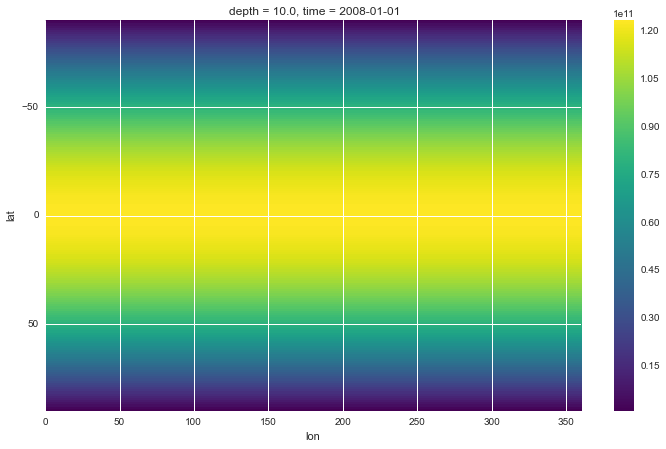

In [124]:
vol[0,1].plot()

In [130]:
dz[0,0]

<xray.DataArray 'thick' (lat: 180, lon: 360)>
array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 -82.5 ...
    depth    float64 0.0
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5 ...
    time     datetime64[ns] 2008-01-01
Attributes:
    axis: Z
    positive: down
    standard_name: depth
    uniquename: depth
    description: Standard Depth Levels
    units: m
    gridtype: 0